In [9]:
#imports
from skimage import io, feature, measure, morphology
from matplotlib import pyplot as plt
import numpy as np
from math import *
import cv2
from skimage import filters
from sklearn.metrics import confusion_matrix
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
import sys
import os

#imports for widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [10]:
#functions
def compareMatrixes(expert, algorithm):
    '''
            \ Algorithm
     Expert  \   1  0
              \_________
            1 |  a||b       TP||FN
              |--------     ------
            0 |  c||d       FP||TN
    '''
    expert1d = expert.ravel()
    algorithm1d = algorithm.ravel()
    tn, fp, fn, tp = confusion_matrix(expert1d, algorithm1d).ravel()
    #print(tn, fp, fn, tp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    print("Sensitivity = ", sensitivity, "Specificity = ", specificity, "Accuracy = ", accuracy)

def removeFrame(image, mask):
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y][x] == 0:
                image[y][x] = 0
    return image

def createDataset(originalImage, expertImage, k):
    X = []
    Y = []
    black = 0
    white = 0
    h, w = expertImage.shape
    r = k // 2
    
    '''
    for y in range(r, h - r):
        for x in range(r, w - r):
            decision = expertImage[y][x]
            square = originalImage[y - r: y + r + 1, x - r: x + r + 1]
            avg = np.average(square)
            median = np.median(square)
            variance = np.var(square)
            X.append([avg, median, variance])
            Y.append(decision)
        if (y % 100 == 0):
            print(y, "/", h-r)
    '''

    for i in range(0, h * w // 1000):
        while True:
            xPos = random.randrange(k, w - k)
            yPos = random.randrange(k, h - k)
            decision = expertImage[yPos][xPos]
            if decision == 255 * (i % 2):
                break

        if decision > 0:
            white += 1
        else:
            black += 1
        square = originalImage[yPos - r: yPos + r + 1, xPos - r: xPos + r + 1]
        avg = np.average(square)
        median = np.median(square)
        variance = np.var(square)
        X.append([avg, median, variance])
        Y.append(decision)
    
    '''while (Y.count(0) < len(Y) * 65 / 100):
        index = Y.index(255)
        Y.pop(index)
        X.pop(index)
        white -= 1
        print("white = ", white)
    '''
    #print("avg = ", avg, "median = ", median, "variance = ", variance)
    #print(square)
    #print("white = ", white, " black = ", black)
    return X, Y

def knn(originalImage, expertImage, X, Y):
    originalOutput = np.zeros_like(originalImage)
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X, Y)
    r = 5 // 2
    divideParts = 5
    
    #for y in range(r , originalImage.shape[0] - r):
    #    for x in range(r + 2 * (originalImage.shape[1] - r) // divideParts, 4 * (originalImage.shape[1] - r) // divideParts):
    for y in range(r + (3 *(originalImage.shape[0] - r)) // divideParts, 4 * (originalImage.shape[0] - r) // divideParts):    
        for x in range(r, originalImage.shape[1] - r):
            square = originalImage[y - r: y + r + 1, x - r : x + r + 1]
            avg = np.average(square)
            median = np.median(square)
            variance = np.var(square)
            originalOutput[y][x] = classifier.predict([[avg, median, variance]])
        sys.stdout.write(str(y) + " / " + str(4 * (originalImage.shape[0] - r) // divideParts) + '\r')
        sys.stdout.flush()
    return originalOutput


In [11]:
def main(example, learn):
    
    fileName = str(example) + "_h.jpg"
    catalogName = "healthy"

    fileNameMask = str(example) + "_h_mask.tif"
    catalogNameMask = "healthy_fovmask"

    fileNameExpert = str(example) + "_h.tif"
    catalogNameExpert = "healthy_manualsegm"
    
    learnFileName = str(learn) + "_h.jpg"
    learnFileNameExpert = str(learn) + "_h.tif"

    resultCatalog = "output"

    image = io.imread(catalogName + "/" + fileName)
    plt.imsave(resultCatalog + "/" + str(example) + "_Example.png", image)
    print("Original photo:")
    io.imshow(image)
    plt.show()

    #green channel
    originalImage = image[:, :, 1]
    plt.imsave(resultCatalog + "/" + str(example) + "_Green.png", originalImage, cmap='gray')
    print("Green channel:")
    io.imshow(originalImage)
    plt.show()
    
    #frangiFilter
    frangiImage = filters.frangi(originalImage)
    for y in range(frangiImage.shape[0]):
        for x in range(frangiImage.shape[1]):
            if frangiImage[y][x] > 0.0000002:
                frangiImage[y][x] = 255
            else:
                frangiImage[y][x] = 0
    outputImage = frangiImage

    #cut frame
    emptyMask = io.imread(catalogNameMask + "/" + fileNameMask)
    emptyMask = cv2.cvtColor(emptyMask, cv2.COLOR_BGR2GRAY)
    frangiImage = removeFrame(frangiImage, emptyMask)
    plt.imsave(resultCatalog + "/" + str(example) + "_Frangi.png", frangiImage, cmap='gray')
    print("Frangi:")
    io.imshow(frangiImage, cmap='gray')
    plt.show()

    expertImage = cv2.imread(catalogNameExpert + "/" + fileNameExpert)
    expertImage = cv2.cvtColor(expertImage, cv2.COLOR_BGR2GRAY)
    plt.imsave(resultCatalog + "/" + str(example) + "_ExpertImage.png", expertImage, cmap='gray')
    print("ExpertImage:")
    io.imshow(expertImage)
    plt.show()
    
    compareMatrixes(expertImage, outputImage)

    #####################################
    
    r = 5 // 2
    divideParts = 5
    #squareExpertImage = expertImage[r + (3 * (originalImage.shape[0] - r)) // divideParts : 4 * (originalImage.shape[0] - r) // divideParts,
                        #r + 2 * (originalImage.shape[1] - r) // divideParts :  4 * (originalImage.shape[1] - r) // divideParts]
    
    learnImage = io.imread(catalogName + "/" + learnFileName)
    learnImage = cv2.cvtColor(learnImage, cv2.COLOR_BGR2GRAY)
    
    learnExpert = cv2.imread(catalogNameExpert + "/" + learnFileNameExpert)
    learnExpert = cv2.cvtColor(learnExpert, cv2.COLOR_BGR2GRAY)
    
    X, Y = createDataset(learnImage, learnExpert, 5)
    
    knnImage = knn(originalImage, expertImage, X, Y)
    plt.imsave(resultCatalog + "/" + str(example) + "_knnImage.png", knnImage, cmap='gray')
    print("\nkNN:")
    io.imshow(knnImage)
    plt.show()
    #knnImage = knnImage[r + (3 * (ori ginalImage.shape[0] - r)) // divideParts : 4 * (originalImage.shape[0] - r) // divideParts,
                        #r + 2 * (originalImage.shape[1] - r) // divideParts :  4 * (originalImage.shape[1] - r) // divideParts]
    #print(squareExpertImage.shape, knnImage.shape)

    knnImageAfterErosion = morphology.erosion(knnImage)
    plt.imsave(resultCatalog + "/" + str(example) + "_knnImageAfterErosion.png", knnImageAfterErosion, cmap='gray')
    print("kNN after erosion:")
    io.imshow(knnImageAfterErosion)
    plt.show()
    print("first=", expertImage.shape, knnImageAfterErosion.shape)
    #cut processing strip to compare
    expertImage = expertImage[3*expertImage.shape[0] // 5 : 4*expertImage.shape[0] // 5, :]
    knnImageAfterErosion = knnImageAfterErosion[3*knnImageAfterErosion.shape[0] // 5 : 4*knnImageAfterErosion.shape[0] // 5, :]
    print(expertImage.shape, knnImageAfterErosion.shape)
    compareMatrixes(expertImage, knnImageAfterErosion)
    
    

ToggleButtons(description='Image:', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg', '07_h.jpg', '08_h.jpg', '09_h.jpg', '10_h.jpg', '11_h.jpg', '12_h.jpg', '13_h.jpg', '14_h.jpg', '15_h.jpg'), value='01_h.jpg')

ToggleButtons(description='Learn image:', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg', '07_h.jpg', '08_h.jpg', '09_h.jpg', '10_h.jpg', '11_h.jpg', '12_h.jpg', '13_h.jpg', '14_h.jpg', '15_h.jpg'), value='01_h.jpg')

Button(description='Execute', style=ButtonStyle())

Original photo:


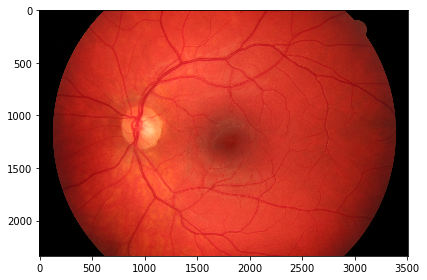

Green channel:


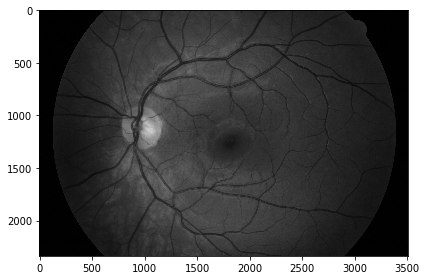

Frangi:


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


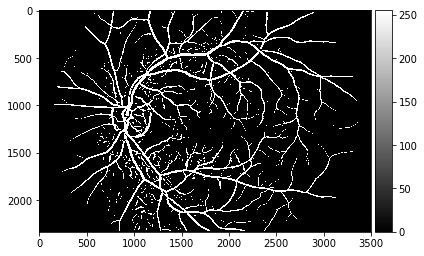

ExpertImage:


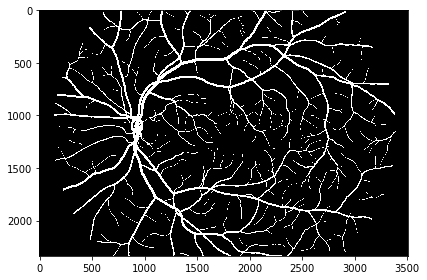

Sensitivity =  0.77878722293 Specificity =  0.971681106291 Accuracy =  0.953497739374


In [12]:
#GUI:
imageChooseButtons = widgets.ToggleButtons(
    options=sorted(os.listdir('healthy')),
    description='Image:',
    disabled=False
)

learnImageButtons = widgets.ToggleButtons(
    options=sorted(os.listdir('healthy')),
    description='Learn image:',
    disabled=False
)

executeButton = widgets.Button(description='Execute')

display(imageChooseButtons)
display(learnImageButtons)
display(executeButton)

def myClick(b):
    main(imageChooseButtons.value[:2], learnImageButtons.value[:2])

executeButton.on_click(myClick)



